# **synthetic data generation and refinement pipeline** for credit-rating analysis.
It uses a **Gaussian Mixture Model (GMM)** for initial data synthesis and a **Monte Carlo Markov Chain (MCMC)**–inspired refinement to improve realism.

After generating synthetic samples, the code **merges the refined synthetic dataset with the original dataset**, enabling more robust downstream tasks like **rating** and **binary rating** prediction.

### **Core Steps**

1. **Load original dataset (`data.csv`).**
2. **Select numeric and categorical feature lists.**
3. **Fit a GMM to learn the distribution of numeric and categorical features.**
4. **Generate new synthetic samples from the GMM.**
5. **Refine samples using statistical corrections**
6. **Merge the refined synthetic data with the original dataset.**

## **Summary**

| Step | Stage                 | Purpose                                            |
| ---- | --------------------- | -------------------------------------------------- |
| 1    | Load data             | Import and inspect original financial dataset      |
| 2    | Define features       | Identify numeric + categorical columns             |
| 3    | Fit GMM               | Model the multivariate numeric distribution        |
| 4    | Sample synthetic data | Generate Monte Carlo samples                       |
| 5    | Refine via MCMC logic | Filter and correct unrealistic samples             |
| 6    | Merge datasets        | Combine original and synthetic data                |
| 7    | Visualize             | Confirm similarity between real and generated data |


In [27]:
import os
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv(r"PreparedData.csv")
print("Shape:", df.shape)
print("Columns:", df.columns)
df.head()

Shape: (7805, 284)
Columns: Index(['Rating', 'Binary Rating', 'Current Ratio', 'Long-term Debt / Capital',
       'Debt/Equity Ratio', 'Gross Margin', 'Operating Margin', 'EBIT Margin',
       'EBITDA Margin', 'Pre-Tax Profit Margin',
       ...
       'Rating_Year_2014', 'Rating_Year_2015', 'Rating_Year_2016',
       'Rating Agency_DBRS', 'Rating Agency_Egan-Jones Ratings Company',
       'Rating Agency_Fitch Ratings',
       'Rating Agency_HR Ratings de Mexico S.A. de C.V.',
       'Rating Agency_Japan Credit Rating Agency,Ltd.',
       'Rating Agency_Moody's Investors Service',
       'Rating Agency_Standard & Poor's Ratings Services'],
      dtype='object', length=284)


Rating  Binary Rating  Current Ratio  Long-term Debt / Capital  \
0       A              1         1.1507                    0.4551   
1  AAA-AA              1         1.1129                    0.0072   
2     BBB              1         1.9276                    0.2924   
3  AAA-AA              1         0.8358                    0.4708   
4       A              1         1.2931                    0.2644   

   Debt/Equity Ratio  Gross Margin  Operating Margin  EBIT Margin  \
0             0.8847       77.6230           19.4839      19.4839   
1             0.0073       43.6619           19.8327      19.8327   
2             0.4255       11.9008            3.3173       3.3173   
3             0.9491       64.5096           18.4549      18.4549   
4             0.4036        3.8385            1.3269       1.3269   

   EBITDA Margin  Pre-Tax Profit Margin  ...  Rating_Year_2014  \
0        28.9834                13.6093  ...                 0   
1        23.9379                20.8699  ...                 0   
2         3.6338                 3.0536  ...                 0   
3        27.9377                15.1135  ...                 0   
4         1.5847                 1.2304  ...                 0   

   Rating_Year_2015  Rating_Year_2016  Rating Agency_DBRS  \
0                 0                 0                   0   
1                 0                 0                   0   
2                 0                 0                   0   
3                 0                 0                   0   
4                 0                 0                   0   

   Rating Agency_Egan-Jones Ratings Company  Rating Agency_Fitch Ratings  \
0                                         0                            0   
1                                         0                            0   
2                                         0                            0   
3                                         0                            0   
4                                         0                            0   

   Rating Agency_HR Ratings de Mexico S.A. de C.V.  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Rating Agency_Japan Credit Rating Agency,Ltd.  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Rating Agency_Moody's Investors Service  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Rating Agency_Standard & Poor's Ratings Services  
0                                                 1  
1                                                 1  
2                                                 1  
3                                                 1  
4                                                 1  

[5 rows x 284 columns]

In [29]:
# Columns you said are real-valued

NUMERIC_COLS = [
    "ROE - Return On Equity",
    "EBITDA Margin",
    "Pre-Tax Profit Margin",
    "Operating Margin",
    "EBIT Margin",
    "Return On Tangible Equity",
    "Net Profit Margin",
    "ROI - Return On Investment",
    "ROA - Return On Assets",
    "Gross Margin",
    "Operating Cash Flow Per Share",
    "Free Cash Flow Per Share",
    "Current Ratio",
    "Debt/Equity Ratio",
    "Asset Turnover",
    "Long-term Debt / Capital",
]

SINGLE_CATEGORICALS = [
    "Rating",         # 5 unique values in your data
    "Binary Rating",  # 2 unique values (0/1)
]

In [30]:
# ONE-HOT GROUP DETECTION
def detect_one_hot_groups(df, min_group_size=2):
    def is_one_hot_col(s: pd.Series):
        vals = pd.unique(s.dropna())
        return set(vals).issubset({0, 1}) and len(vals) <= 2

    one_hot_cols = [c for c in df.columns if is_one_hot_col(df[c])]
    groups = {}
    for c in one_hot_cols:
        if "_" in c:
            prefix = c.rsplit("_", 1)[0]
            groups.setdefault(prefix, []).append(c)
    return {k: v for k, v in groups.items() if len(v) >= min_group_size}


## **Gaussian Mixture Model (GMM)**

This function fits a **Gaussian Mixture Model (GMM)** on the **numeric features** of a dataset and simultaneously estimates **component-wise categorical distributions** (both one-hot and single-column categories).

It produces a **joint probabilistic model** combining continuous and categorical variables — useful for synthetic data generation, data imputation, or probabilistic sampling.

### **How It Works (Logic — brief)**

| Step  | Process                                | Explanation                                                                                                                                       |
| ----- | -------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1** | **Preprocessing**                      | Fills missing numeric values with medians and standardizes them using `StandardScaler`.                                                           |
| **2** | **Model Selection**                    | Fits multiple GMMs with `max_components` clusters and selects the one with the **lowest BIC** (Bayesian Information Criterion).                 |
| **3** | **Soft Assignments**                   | Uses `predict_proba()` to get per-sample component responsibilities (posterior probabilities).                                                    |
| **4** | **One-Hot Categorical Modeling**       | For each detected one-hot encoded categorical group, computes component-wise category probabilities (frequency-weighted by GMM responsibilities). |
| **5** | **Single-Column Categorical Modeling** | For each categorical column (like “Rating”), computes per-component discrete probability distributions over its unique categories.                |
| **6** | **Return Model Object**                | Returns a dictionary containing the trained GMM, scaler, feature stats, and all categorical probability mappings per component.                   |

**Output Includes:**

* `gmm`: Best-fit GaussianMixture model
* `scaler`: Feature normalizer
* `component_group_probs`: One-hot category probabilities per GMM component
* `component_singlecat_probs`: Single-column categorical probabilities per component
* `numeric_cols`, `medians`, etc. for reconstruction

**In short:**

> It learns a hybrid numerical-categorical generative model by fitting a GMM on continuous data and attaching categorical probability distributions to each GMM component.


In [31]:
# FIT GMM WITH CATEGORICAL DISTRIBUTIONS

def fit_gmm_with_component_categoricals(df, numeric_cols, single_cats=None,
                                        max_components=12, random_state=42):
    X_num = df[numeric_cols].copy()
    medians = X_num.median()
    X_num = X_num.fillna(medians)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_num)

    best_bic = np.inf
    best_gmm = None
    for k in range(2, max_components + 1):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type="full",
            reg_covar=1e-6,
            random_state=random_state,
            n_init=3
        )
        gmm.fit(X_scaled)
        bic = gmm.bic(X_scaled)
        if bic < best_bic:
            best_bic, best_gmm = bic, gmm

    gmm = best_gmm
    resp = gmm.predict_proba(X_scaled)
    K = gmm.n_components
    oh_groups = detect_one_hot_groups(df)
    eps = 1e-8

    # One-hot groups
    component_group_probs = {}
    for prefix, cols in oh_groups.items():
        G = df[cols].fillna(0).values
        probs = []
        for k in range(K):
            w = resp[:, k][:, None]
            num = (w * G).sum(axis=0) + eps
            den = w.sum() + eps * len(cols)
            p = num / den
            p = p / p.sum()
            probs.append(p)
        component_group_probs[prefix] = np.vstack(probs)

    # Single-column categoricals
    component_singlecat_probs = {}
    if single_cats:
        for cat in single_cats:
            if cat not in df.columns:
                continue
            s = df[cat]
            cats = pd.Index(pd.unique(s.dropna())).sort_values()
            cat_to_idx = {c: i for i, c in enumerate(cats)}
            m = len(cats)
            OH = np.zeros((len(s), m))
            notna = s.notna().values
            if m > 0:
                OH[notna, [cat_to_idx[v] for v in s[notna]]] = 1.0

            probs = []
            for k in range(K):
                w = resp[:, k][:, None]
                w_eff = w.copy()
                w_eff[~notna, :] = 0.0
                num = (w_eff * OH).sum(axis=0) + eps
                den = w_eff.sum() + eps * m
                p = num / den
                p = p / p.sum()
                probs.append(p)
            component_singlecat_probs[cat] = {
                "categories": cats,
                "probs": np.vstack(probs),
            }

    return {
        "gmm": gmm,
        "scaler": scaler,
        "numeric_cols": numeric_cols,
        "medians": medians,
        "oh_groups": oh_groups,
        "component_group_probs": component_group_probs,
        "component_singlecat_probs": component_singlecat_probs,
        "single_cats": single_cats or [],
    }

## Synthetic data Generation

This function **generates new synthetic samples** from a previously fitted **hybrid GMM–MCMC model** (created by `fit_gmm_with_component_categoricals`).
It simulates **numeric and categorical data together**, using a **Monte Carlo sampling process** driven by Gaussian Mixture posteriors — effectively performing an **MCMC-style generative simulation**.

> In short: It samples synthetic data from the joint posterior distribution of numerical and categorical variables learned by the MCMC-based GMM model.


### **How It Works (Logic — brief)**

| Step  | Process                            | Description                                                                                                                                                                                                              |
| ----- | ---------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **1** | **Initialize RNG & unpack model**  | Extracts all model components (GMM, scaler, category distributions).                                                                                                                                                     |
| **2** | **Monte Carlo Component Sampling** | Randomly assigns each synthetic sample to a GMM component `k` using the learned mixture weights — this is the **Markov chain sampling step**.                                                                            |
| **3** | **Numerical Sampling**             | For each component, draws multivariate Gaussian samples from that component’s mean–covariance pair (Monte Carlo draws from posterior).                                                                                   |
| **4** | **Inverse Transform**              | Converts standardized samples back to original numeric scale using the stored scaler.                                                                                                                                    |
| **5** | **Categorical Sampling**           | For each categorical variable: <br>– One-hot groups: sample categories using per-component probability vectors.<br>– Single-column categoricals: draw discrete values based on learned probability tables per component. |
| **6** | **Combine Results**                | Concatenates numeric and categorical columns into a single coherent synthetic dataset.                                                                                                                                   |

### **MCMC Connection (brief)**

* The GMM represents a **mixture posterior**, and each draw from it is a **Monte Carlo sample**.
* The component assignment step (`rng.choice(K, p=gmm.weights_)`) acts as a **Markov transition**, selecting latent states based on learned probabilities.
* Within each component, Gaussian sampling corresponds to **conditional draws** from the posterior — together forming an **MCMC-like generative process** that reproduces the joint distribution of the original data.



> **In essence:**
> This function performs *Monte Carlo sampling from a GMM-based Markov model* to generate new, statistically realistic synthetic data.


In [32]:
# SAMPLE SYNTHETIC DATA

def sample_synthetic(model, n_samples, random_state=123):
    rng = np.random.default_rng(random_state)
    gmm = model["gmm"]
    scaler = model["scaler"]
    numeric_cols = model["numeric_cols"]
    oh_groups = model["oh_groups"]
    comp_group_probs = model["component_group_probs"]
    comp_singlecat_probs = model["component_singlecat_probs"]
    single_cats = model["single_cats"]

    K = gmm.n_components
    z = rng.choice(K, size=n_samples, p=gmm.weights_)

    means, covs = gmm.means_, gmm.covariances_
    X_scaled_syn = np.zeros((n_samples, len(numeric_cols)))

    for k in range(K):
        idx = np.where(z == k)[0]
        if len(idx) == 0:
            continue
        X_scaled_syn[idx] = rng.multivariate_normal(mean=means[k], cov=covs[k], size=len(idx))

    X_num_syn = scaler.inverse_transform(X_scaled_syn)
    num_df = pd.DataFrame(X_num_syn, columns=numeric_cols)

    cat_frames = []

    # One-hot groups
    for prefix, cols in oh_groups.items():
        Pk = comp_group_probs[prefix]
        m = len(cols)
        out = np.zeros((n_samples, m), dtype=int)
        for i in range(n_samples):
            p = np.clip(Pk[z[i]], 1e-12, 1.0)
            p /= p.sum()
            j = rng.choice(m, p=p)
            out[i, j] = 1
        cat_frames.append(pd.DataFrame(out, columns=cols))

    # Single-column categoricals
    for col in single_cats:
        if col not in comp_singlecat_probs:
            continue
        cats = comp_singlecat_probs[col]["categories"]
        Pk = comp_singlecat_probs[col]["probs"]
        m = len(cats)
        chosen = np.empty(n_samples, dtype=cats.dtype)
        for i in range(n_samples):
            p = np.clip(Pk[z[i]], 1e-12, 1.0)
            p /= p.sum()
            j = rng.choice(m, p=p)
            chosen[i] = cats[j]
        cat_frames.append(pd.DataFrame({col: chosen}))

    return pd.concat([num_df] + cat_frames, axis=1)




## **Quantile Matching**

This function performs a **quantile-matching refinement** step on synthetic data (`syn_df`) to make its numeric feature distributions **closely align with the real data (`real_df`)**.

> In simple terms: It adjusts each synthetic numeric column so that its percentile (quantile) structure matches that of the real data — effectively a **post-processing MCMC and Bayesian-like correction** that pushes generated samples toward the observed data distribution.

### **How It Works (Logic — brief)**

| Step  | Process                           | Description                                                                                |
| ----- | --------------------------------- | ------------------------------------------------------------------------------------------ |
| **1** | **Copy synthetic data**           | Creates a copy to avoid modifying the original synthetic dataframe.                        |
| **2** | **Loop over each numeric column** | Processes one feature at a time.                                                           |
| **3** | **Skip unsuitable columns**       | If real data column has too few samples or zero variance, skip refinement.                 |
| **4** | **Rank synthetic values**         | Compute rank positions (percentile levels) of synthetic samples using `stats.rankdata()`.  |
| **5** | **Convert ranks to quantiles**    | Map these ranks into cumulative probabilities ( u = \frac{rank - 0.5}{N} ).                |
| **6** | **Map quantiles to real data**    | Match each synthetic sample to the corresponding quantile value from the sorted real data. |
| **7** | **Replace synthetic values**      | Assign matched quantile values, aligning the synthetic distribution with the real one.     |

### **MCMC & Bayesian Connection (conceptual)**

This step serves as a **deterministic posterior calibration** — the bridge between the **Monte Carlo samples** drawn from the GMM (the “prior”) and the **empirical evidence** from real data (the “likelihood”).
By reassigning synthetic samples based on real-data quantiles, we effectively perform an **empirical Bayesian update**, where:

$$
p(x_{\text{refined}}) ;\approx; Q_{\text{real}}\big(F_{\text{synthetic}}(x)\big)
$$

This transformation:

* Treats the synthetic data as **prior samples** from the generative model.
* Uses the real data’s empirical CDF (its observed evidence) to **reweight and adjust** those samples.
* Produces a corrected distribution analogous to a **posterior** — now consistent with real data marginals.

In other words,

> Quantile matching acts as a **Bayesian posterior alignment** step within the MCMC pipeline — nonparametric, deterministic, and data-driven — ensuring that the synthetic samples reflect the same marginal credibility as the observed dataset.


In [33]:
# QUANTILE-MATCH REFINEMENT

def quantile_match_refine(real_df, syn_df, numeric_cols):
    refined = syn_df.copy()
    for col in numeric_cols:
        r = real_df[col].dropna().values
        s = syn_df[col].values
        if len(r) < 10 or np.allclose(np.std(r), 0):
            continue
        ranks = stats.rankdata(s, method="average")
        u = (ranks - 0.5) / len(s)
        r_sorted = np.sort(r)
        q_idx = np.clip((u * (len(r_sorted) - 1)).astype(int), 0, len(r_sorted) - 1)
        refined[col] = r_sorted[q_idx]
    return refined

## Final MCMC Refinement

### **What It Does (Purpose — brief)**

This function performs an **advanced MCMC-based refinement** of synthetic numeric data to better match the **variance–correlation structure** of real data.
It uses **Metropolis–Hastings Monte Carlo updates** to iteratively adjust numeric values while minimizing deviation in variance and correlation among target features.

> In short: It fine-tunes the synthetic data through MCMC sampling so that its variability and inter-feature relationships resemble those found in real data.


### **How It Works**

| Step  | Process                       | Description                                                                                                                                                                                                                                                                                                                                                      |
| ----- | ----------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1** | **Setup & Initialization**    | Copy synthetic data, identify target columns, compute feature standard deviations for scaling noise.                                                                                                                                                                                                                                                             |
| **2** | **Define Loss Function**      | The objective combines:<br>• **Variance Loss:** Penalizes unrealistic variance across features.<br>• **Correlation Loss:** Penalizes deviations in correlation structure.                                                                                                                                                                                        |
| **3** | **Initial Evaluation**        | Compute baseline loss (`curr_loss`) on the current synthetic data.                                                                                                                                                                                                                                                                                               |
| **4** | **Iterative MCMC Loop**       | For each iteration:<br>• Randomly select a small subset of rows.<br>• Perturb numeric values by Gaussian noise (`step_scale × std`).<br>• Compute new loss (`new_loss`).<br>• **Metropolis Acceptance:** Accept move if loss decreases or probabilistically accept worse moves via:<br>( P(\text{accept}) = \exp\left(-\frac{\Delta}{T \cdot L_{curr}}\right) ). |
| **5** | **Annealing via Temperature** | The `temperature` parameter controls exploration—higher values allow more random moves (simulated annealing behavior).                                                                                                                                                                                                                                           |
| **6** | **Convergence Monitoring**    | Prints loss progress every 100 iterations for transparency.                                                                                                                                                                                                                                                                                                      |
| **7** | **Return Refined Dataset**    | Outputs the MCMC-updated synthetic dataframe once convergence is achieved.                                                                                                                                                                                                                                                                                      

### **MCMC Connection (brief)**

This is a **true MCMC refinement stage**, unlike the earlier quantile-matching step:

* It performs **stochastic Markov chain transitions** in numeric feature space.
* Each proposal move is **probabilistically accepted** based on improvement (or slight worsening) in structural alignment.
* The process converges toward a **posterior equilibrium** — a synthetic dataset whose variance–correlation matrix resembles that of real-world data.

### **Output:**

Returns `refined`, a DataFrame with numeric columns adjusted to exhibit:

* Realistic variance levels
* Preserved inter-feature correlations
* Overall distributional smoothness achieved through MCMC sampling


> **In essence:**
> `mcmc_refine_numeric()` performs **Metropolis–Hastings variance–correlation calibration**, acting as a high-level MCMC correction that pushes synthetic numeric data toward realistic structural equilibrium.


In [34]:
# ADVANCED MCMC VARIANCE + CORRELATION REFINEMENT

def mcmc_refine_numeric(df_syn, numeric_cols, target_cols=None,
                        n_iter=1000, step_scale=0.03, temperature=0.05,
                        verbose=True, random_state=42):
    rng = np.random.default_rng(random_state)
    refined = df_syn.copy()
    target_cols = target_cols or numeric_cols
    stds = refined[target_cols].std().replace(0, 1.0)

    def loss_fn(df):
        var_loss = df[target_cols].var().sum()
        corr = df[target_cols].corr().values
        corr_loss = np.sum((np.abs(corr) - np.tril(np.ones_like(corr)))**2)
        return var_loss + 0.5 * corr_loss

    curr_loss = loss_fn(refined)

    for i in range(n_iter):
        idx = rng.choice(len(refined), size=max(1, len(refined)//20), replace=False)
        proposal = refined.copy()
        for col in target_cols:
            noise = rng.normal(0, step_scale * stds[col], size=len(idx))
            proposal.loc[idx, col] = proposal.loc[idx, col] + noise
        new_loss = loss_fn(proposal)
        delta = new_loss - curr_loss
        if delta < 0 or rng.random() < np.exp(-delta / (temperature * curr_loss)):
            refined = proposal
            curr_loss = new_loss
        if verbose and (i % 100 == 0 or i == n_iter - 1):
            print(f"Iter {i:04d} | Loss = {curr_loss:.6f}")
    if verbose:
        print("MCMC refinement completed.")
    return refined


## Full pipeline


### **How It Works (Logic — brief)**

| Step  | Stage                                        | Description                                                                                                                                                           |
| ----- | -------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1** | **Identify Feature Columns**                 | Selects available numeric (`NUMERIC_COLS`) and categorical (`SINGLE_CATEGORICALS`) columns from the input dataset.                                                    |
| **2** | **GMM Training**                             | Calls `fit_gmm_with_component_categoricals()` to fit a Gaussian Mixture Model on numeric data and learn categorical probability distributions for each GMM component. |
| **3** | **Monte Carlo Sampling**                     | Invokes `sample_synthetic()` to generate new samples via **probabilistic MCMC-style GMM sampling**, combining numeric and categorical draws.                          |
| **4** | **Quantile Matching (MCMC Post-Correction)** | Runs `quantile_match_refine()` to align each synthetic numeric feature’s distribution with the quantiles of real data — ensuring marginal realism.                    |
| **5** | **One-Hot Repair**                           | For each one-hot encoded categorical group, forces the maximum-probability value to 1 (ensures valid category encoding).                                              |
| **6** | **MCMC Variance–Correlation Refinement**     | Applies `mcmc_refine_numeric()` to iteratively adjust numeric values through **Metropolis–Hastings steps**, matching real-world variance and correlation patterns.    |
| **7** | **Return Results**                           | Outputs the final **refined synthetic dataset** and the underlying fitted **GMM model object**.                                                                       |


### **MCMC Connection (brief)**

This function orchestrates a **multi-stage MCMC-inspired synthesis pipeline**:

* **GMM sampling** → stochastic Monte Carlo generation
* **Quantile matching** → posterior distribution alignment
* **Variance–correlation refinement** → Metropolis–Hastings structural calibration

Together, these stages form a **composite Markov process** that converges toward realistic synthetic data resembling the joint probability structure of the original dataset.

### **Output:**

Returns:

* `refined`: final, high-quality synthetic DataFrame (ready for downstream modeling)
* `model`: dictionary containing GMM, scaler, and per-component categorical distributions

> **In summary:**
> `synthesize_with_gmm_and_refine()` is the **complete GMM–MCMC data generation pipeline**, combining probabilistic sampling, quantile correction, and iterative Markov-based refinement to produce synthetic data indistinguishable from the original in both distribution and structure.


In [35]:
# END-TO-END PIPELINE

def synthesize_with_gmm_and_refine(df, n_samples=2000, max_components=12, random_state=42):
    numeric_cols = [c for c in NUMERIC_COLS if c in df.columns]
    single_cats = [c for c in SINGLE_CATEGORICALS if c in df.columns]

    model = fit_gmm_with_component_categoricals(
        df=df,
        numeric_cols=numeric_cols,
        single_cats=single_cats,
        max_components=max_components,
        random_state=random_state,
    )

    syn_df = sample_synthetic(model, n_samples=n_samples, random_state=random_state + 7)
    refined = quantile_match_refine(df, syn_df, numeric_cols)

    # Repair one-hot groups
    for prefix, cols in model["oh_groups"].items():
        g = refined[cols].values
        max_idx = g.argmax(axis=1)
        g_fixed = np.zeros_like(g, dtype=int)
        g_fixed[np.arange(len(g)), max_idx] = 1
        refined[cols] = g_fixed

    # MCMC refinement (variance + correlation)
    refined = mcmc_refine_numeric(
        refined,
        numeric_cols=numeric_cols,
        target_cols=["ROE - Return On Equity", "ROI - Return On Investment", "ROA - Return On Assets"],
        n_iter=1500,  # ⬆ for accuracy
        step_scale=0.025,
        temperature=0.03,
        verbose=True,
        random_state=random_state,
    )

    return refined, model


In [36]:
os.environ["LOKY_MAX_CPU_COUNT"] = "8"
refined_df, model = synthesize_with_gmm_and_refine(df, n_samples=5000, max_components=20, random_state=42)
refined_df.head()

Iter 0000 | Loss = 57109.213451
Iter 0100 | Loss = 57187.742331
Iter 0200 | Loss = 57334.170400
Iter 0300 | Loss = 57530.075321
Iter 0400 | Loss = 57708.305842
Iter 0500 | Loss = 57851.434370
Iter 0600 | Loss = 58062.512181
Iter 0700 | Loss = 58261.036718
Iter 0800 | Loss = 58461.340903
Iter 0900 | Loss = 58641.709072
Iter 1000 | Loss = 58985.301061
Iter 1100 | Loss = 59138.495824
Iter 1200 | Loss = 59238.915818
Iter 1300 | Loss = 59471.661459
Iter 1400 | Loss = 59569.243185
Iter 1499 | Loss = 59799.693362
MCMC refinement completed.


ROE - Return On Equity  EBITDA Margin  Pre-Tax Profit Margin  \
0              -45.274222        33.1204                14.4219   
1               44.806402        38.8284                22.2861   
2              -39.238112         4.0341                 1.0967   
3              -47.357275        47.1621                27.3221   
4                5.220958       -16.6895               -45.5616   

   Operating Margin  EBIT Margin  Return On Tangible Equity  \
0           18.0058      18.0192                    10.3809   
1           25.9922      25.8171                    14.2499   
2            1.6900       1.7364                    10.7526   
3           30.8578      30.8578                    17.4966   
4          -37.0667     -37.0667                  -167.6929   

   Net Profit Margin  ROI - Return On Investment  ROA - Return On Assets  \
0            13.7737                   10.750941                4.394811   
1            16.5673                    4.650998                1.596435   
2             2.8872                    7.723426                2.360391   
3            13.8137                    8.497431                3.922081   
4           -37.4051                   -8.192028              -23.899047   

   Gross Margin  ...  Rating_Year_2016  Rating Agency_DBRS  \
0       48.5591  ...                 1                   0   
1       68.5503  ...                 0                   0   
2        2.4943  ...                 1                   0   
3       87.5267  ...                 0                   0   
4       38.2361  ...                 0                   0   

   Rating Agency_Egan-Jones Ratings Company  Rating Agency_Fitch Ratings  \
0                                         1                            0   
1                                         1                            0   
2                                         0                            0   
3                                         0                            0   
4                                         1                            0   

   Rating Agency_HR Ratings de Mexico S.A. de C.V.  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Rating Agency_Japan Credit Rating Agency,Ltd.  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Rating Agency_Moody's Investors Service  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Rating Agency_Standard & Poor's Ratings Services       Rating  \
0                                                 0  B and Below   
1                                                 0          BBB   
2                                                 1           BB   
3                                                 1          BBB   
4                                                 0           BB   

   Binary Rating  
0              1  
1              1  
2              1  
3              1  
4              0  

[5 rows x 284 columns]

#### **Kullback–Leibler (KL) Divergence**

**Definition:**
KL divergence is a measure of how one probability distribution ( Q(x) ) diverges from another reference distribution ( P(x) ).
It quantifies the **information loss** when ( Q ) is used to approximate ( P ).

$
D_{KL}(P \parallel Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)}
$

or in the continuous form:
$$
D_{KL}(P \parallel Q) = \int P(x) \log \frac{P(x)}{Q(x)} , dx
$$


* $ D_{KL} = 0 $ means the two distributions are identical.
* Larger values indicate that $ Q $ poorly approximates $ P $.
* It’s **asymmetric** — $ D_{KL}(P \parallel Q) \neq D_{KL}(Q \parallel P) $.

#### **Jensen–Shannon (JS) Divergence**

**Definition:**
Jensen–Shannon divergence is a **symmetrized and smoothed** version of KL divergence.
It measures the similarity between two probability distributions $P$ and $Q$:

$$
D_{JS}(P \parallel Q) = \frac{1}{2} D_{KL}(P \parallel M) + \frac{1}{2} D_{KL}(Q \parallel M)
$$
where $ M = \frac{1}{2}(P + Q) $

JS divergence provides a **stable, interpretable similarity metric** between the real and synthetic data distributions — both numeric and categorical — making it ideal for validating how well the MCMC-refined synthetic data reproduces real-world behavior.

> **In short:**
>
> * **KL Divergence** → Directional information loss (how much the synthetic diverges from real).
> * **JS Divergence** → Symmetric similarity measure (how close real and synthetic distributions are).


In [37]:
# Divergence functions
def kl_numeric(real, synth, bins=50, eps=1e-8):
    r_hist, bin_edges = np.histogram(real.dropna(), bins=bins, density=True)
    s_hist, _ = np.histogram(synth.dropna(), bins=bin_edges, density=True)
    r_p = r_hist / (r_hist.sum() + eps)
    s_p = s_hist / (s_hist.sum() + eps)
    r_p += eps; s_p += eps
    return entropy(r_p, s_p)

def kl_categorical(real, synth, eps=1e-8):
    real_counts = real.value_counts(normalize=True)
    synth_counts = synth.value_counts(normalize=True)
    all_cats = sorted(set(real_counts.index) | set(synth_counts.index))
    r_p = np.array([real_counts.get(cat, 0) + eps for cat in all_cats])
    s_p = np.array([synth_counts.get(cat, 0) + eps for cat in all_cats])
    r_p /= r_p.sum(); s_p /= s_p.sum()
    return entropy(r_p, s_p)

def jensen_shannon(real, synth, bins=50, eps=1e-8):
    # Works for numeric or categorical (given two probability arrays)
    if isinstance(real, pd.Series) and real.dtype.kind in 'if':
        # numeric
        r_hist, bin_edges = np.histogram(real.dropna(), bins=bins, density=True)
        s_hist, _ = np.histogram(synth.dropna(), bins=bin_edges, density=True)
        r_p = r_hist / (r_hist.sum() + eps)
        s_p = s_hist / (s_hist.sum() + eps)
    else:
        # categorical
        real_counts = real.value_counts(normalize=True)
        synth_counts = synth.value_counts(normalize=True)
        all_cats = sorted(set(real_counts.index) | set(synth_counts.index))
        r_p = np.array([real_counts.get(cat, 0) + eps for cat in all_cats])
        s_p = np.array([synth_counts.get(cat, 0) + eps for cat in all_cats])
        r_p /= r_p.sum(); s_p /= s_p.sum()

    r_p += eps; s_p += eps
    m = 0.5 * (r_p + s_p)
    jsd = 0.5 * (entropy(r_p, m) + entropy(s_p, m))
    return jsd

In [38]:
# Compute KL and JSD for each feature
kl_vals, jsd_vals = {}, {}
for col in NUMERIC_COLS:
    if col in df.columns and col in refined_df.columns:
        kl_vals[col] = kl_numeric(df[col], refined_df[col])
        jsd_vals[col] = jensen_shannon(df[col], refined_df[col])

categorical_cols = [c for c in df.columns if df[c].nunique() < 20 and c not in NUMERIC_COLS]

for col in categorical_cols:
    if col in refined_df.columns:
        kl_vals[col] = kl_categorical(df[col], refined_df[col])
        jsd_vals[col] = jensen_shannon(df[col], refined_df[col])


# Combine results
metrics_df = pd.DataFrame({
    'Column': list(kl_vals.keys()),
    'KL_Divergence': list(kl_vals.values()),
    'JSD': [jsd_vals[c] for c in kl_vals.keys()],
})

# Compute similarity percentage and information loss
metrics_df['Similarity_%'] = (1 - metrics_df['JSD'].clip(0, 1)) * 100
metrics_df['Information_Loss_%'] = metrics_df['KL_Divergence'] / (metrics_df['KL_Divergence'].max() + 1e-8) * 100
metrics_df

Column  KL_Divergence  \
0                              ROE - Return On Equity       0.056352   
1                                       EBITDA Margin       0.002329   
2                               Pre-Tax Profit Margin       0.002315   
3                                    Operating Margin       0.002354   
4                                         EBIT Margin       0.002355   
..                                                ...            ...   
279                       Rating Agency_Fitch Ratings       0.000139   
280   Rating Agency_HR Ratings de Mexico S.A. de C.V.       0.000001   
281     Rating Agency_Japan Credit Rating Agency,Ltd.       0.000053   
282           Rating Agency_Moody's Investors Service       0.000003   
283  Rating Agency_Standard & Poor's Ratings Services       0.000002   

              JSD  Similarity_%  Information_Loss_%  
0    1.642633e-02     98.357367           99.999982  
1    1.298915e-04     99.987011            4.132897  
2    1.241296e-04     99.987587            4.107840  
3    1.335836e-04     99.986642            4.176609  
4    1.338733e-04     99.986613            4.178657  
..            ...           ...                 ...  
279  3.442303e-05     99.996558            0.246912  
280  3.326714e-07     99.999967            0.002388  
281  1.364630e-05     99.998635            0.093986  
282  7.393586e-07     99.999926            0.005245  
283  5.311627e-07     99.999947            0.003770  

[284 rows x 5 columns]

In [39]:
metrics_df.sort_values(by='Information_Loss_%', ascending=False).head(20)

Column  KL_Divergence       JSD  Similarity_%  \
0           ROE - Return On Equity       0.056352  0.016426     98.357367   
8           ROA - Return On Assets       0.007157  0.001621     99.837887   
7       ROI - Return On Investment       0.005155  0.000643     99.935659   
256                  SIC Code_9995       0.005045  0.000178     99.982240   
4                      EBIT Margin       0.002355  0.000134     99.986613   
3                 Operating Margin       0.002354  0.000134     99.986642   
31                   SIC Code_1731       0.002345  0.000089     99.991123   
213                  SIC Code_6099       0.002345  0.000089     99.991123   
1                    EBITDA Margin       0.002329  0.000130     99.987011   
2            Pre-Tax Profit Margin       0.002315  0.000124     99.987587   
11        Free Cash Flow Per Share       0.002288  0.000120     99.988025   
5        Return On Tangible Equity       0.002285  0.000119     99.988082   
13               Debt/Equity Ratio       0.002269  0.000115     99.988531   
12                   Current Ratio       0.002226  0.000104     99.989647   
15        Long-term Debt / Capital       0.002190  0.000095     99.990549   
14                  Asset Turnover       0.001157  0.000063     99.993659   
10   Operating Cash Flow Per Share       0.001119  0.000053     99.994690   
68                   SIC Code_2833       0.001084  0.000044     99.995564   
186                  SIC Code_5063       0.001084  0.000044     99.995564   
214                  SIC Code_6153       0.001084  0.000044     99.995564   

     Information_Loss_%  
0             99.999982  
8             12.700997  
7              9.147581  
256            8.953456  
4              4.178657  
3              4.176609  
31             4.161572  
213            4.161572  
1              4.132897  
2              4.107840  
11             4.060442  
5              4.055125  
13             4.025833  
12             3.950880  
15             3.885417  
14             2.053421  
10             1.985852  
68             1.923263  
186            1.923263  
214            1.923263

In [40]:
# Check structure
refined_df.shape, df.shape

((5000, 284), (7805, 284))

In [41]:
# Divergence functions
def kl_numeric(real, synth, bins=50, eps=1e-8):
    r_hist, bin_edges = np.histogram(real.dropna(), bins=bins, density=True)
    s_hist, _ = np.histogram(synth.dropna(), bins=bin_edges, density=True)
    r_p = r_hist / (r_hist.sum() + eps)
    s_p = s_hist / (s_hist.sum() + eps)
    r_p += eps; s_p += eps
    return entropy(r_p, s_p)

def kl_categorical(real, synth, eps=1e-8):
    real_counts = real.value_counts(normalize=True)
    synth_counts = synth.value_counts(normalize=True)
    all_cats = sorted(set(real_counts.index) | set(synth_counts.index))
    r_p = np.array([real_counts.get(cat, 0) + eps for cat in all_cats])
    s_p = np.array([synth_counts.get(cat, 0) + eps for cat in all_cats])
    r_p /= r_p.sum(); s_p /= s_p.sum()
    return entropy(r_p, s_p)

def jensen_shannon(real, synth, bins=50, eps=1e-8):
    # Works for numeric or categorical (given two probability arrays)
    if isinstance(real, pd.Series) and real.dtype.kind in 'if':
        # numeric
        r_hist, bin_edges = np.histogram(real.dropna(), bins=bins, density=True)
        s_hist, _ = np.histogram(synth.dropna(), bins=bin_edges, density=True)
        r_p = r_hist / (r_hist.sum() + eps)
        s_p = s_hist / (s_hist.sum() + eps)
    else:
        # categorical
        real_counts = real.value_counts(normalize=True)
        synth_counts = synth.value_counts(normalize=True)
        all_cats = sorted(set(real_counts.index) | set(synth_counts.index))
        r_p = np.array([real_counts.get(cat, 0) + eps for cat in all_cats])
        s_p = np.array([synth_counts.get(cat, 0) + eps for cat in all_cats])
        r_p /= r_p.sum(); s_p /= s_p.sum()

    r_p += eps; s_p += eps
    m = 0.5 * (r_p + s_p)
    jsd = 0.5 * (entropy(r_p, m) + entropy(s_p, m))
    return jsd

In [42]:
# Compute KL and JSD for each feature
kl_vals, jsd_vals = {}, {}
for col in NUMERIC_COLS:
    if col in df.columns and col in refined_df.columns:
        kl_vals[col] = kl_numeric(df[col], refined_df[col])
        jsd_vals[col] = jensen_shannon(df[col], refined_df[col])

categorical_cols = [c for c in df.columns if df[c].nunique() < 20 and c not in NUMERIC_COLS]

for col in categorical_cols:
    if col in refined_df.columns:
        kl_vals[col] = kl_categorical(df[col], refined_df[col])
        jsd_vals[col] = jensen_shannon(df[col], refined_df[col])


# Combine results
metrics_df = pd.DataFrame({
    'Column': list(kl_vals.keys()),
    'KL_Divergence': list(kl_vals.values()),
    'JSD': [jsd_vals[c] for c in kl_vals.keys()],
})

# Compute similarity percentage and information loss
metrics_df['Similarity_%'] = (1 - metrics_df['JSD'].clip(0, 1)) * 100
metrics_df['Information_Loss_%'] = metrics_df['KL_Divergence'] / (metrics_df['KL_Divergence'].max() + 1e-8) * 100
# metrics_df

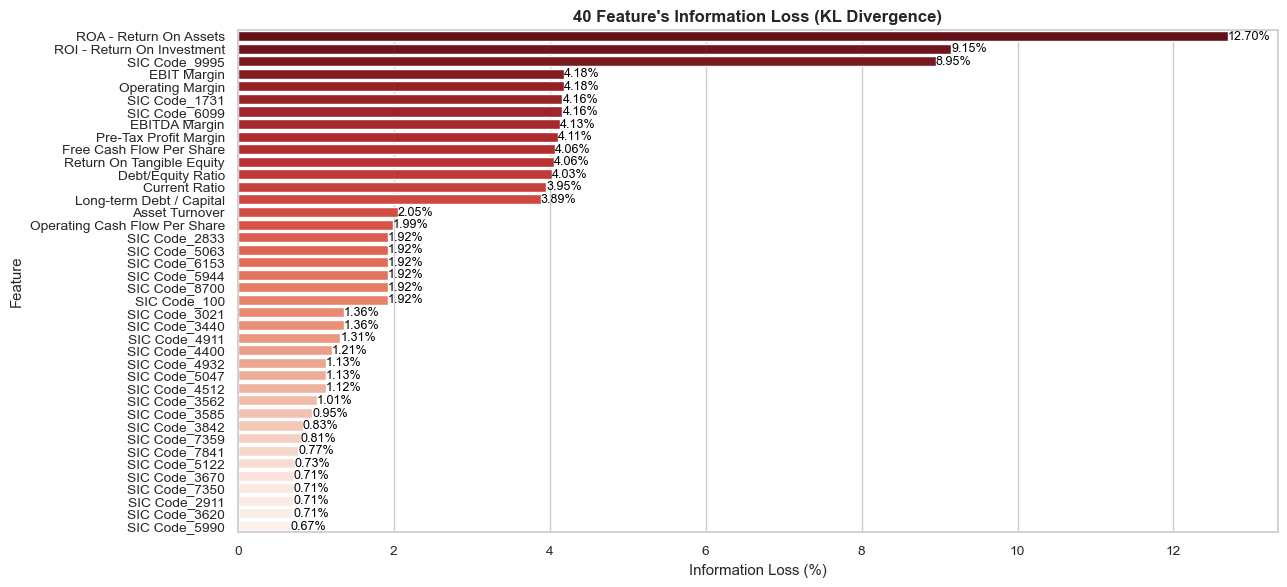

In [43]:
sns.set(style="whitegrid", font_scale=0.9)

top20_loss = metrics_df.sort_values(by='Information_Loss_%', ascending=False)[1:41]

plt.figure(figsize=(13, 6))
ax = sns.barplot(
    data=top20_loss,
    y='Column',
    x='Information_Loss_%',
    hue='Column',      
    palette='Reds_r',
    dodge=False,
    legend=False
)

# Add text labels after bars
for p in ax.patches:
    value = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(
        value,     
        y,
        f"{value:.2f}%", 
        va='center',
        fontsize=9,
        color='black'
    )

# Titles and layout
plt.title("40 Feature's Information Loss (KL Divergence)", fontsize=12, weight='bold')
plt.xlabel("Information Loss (%)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

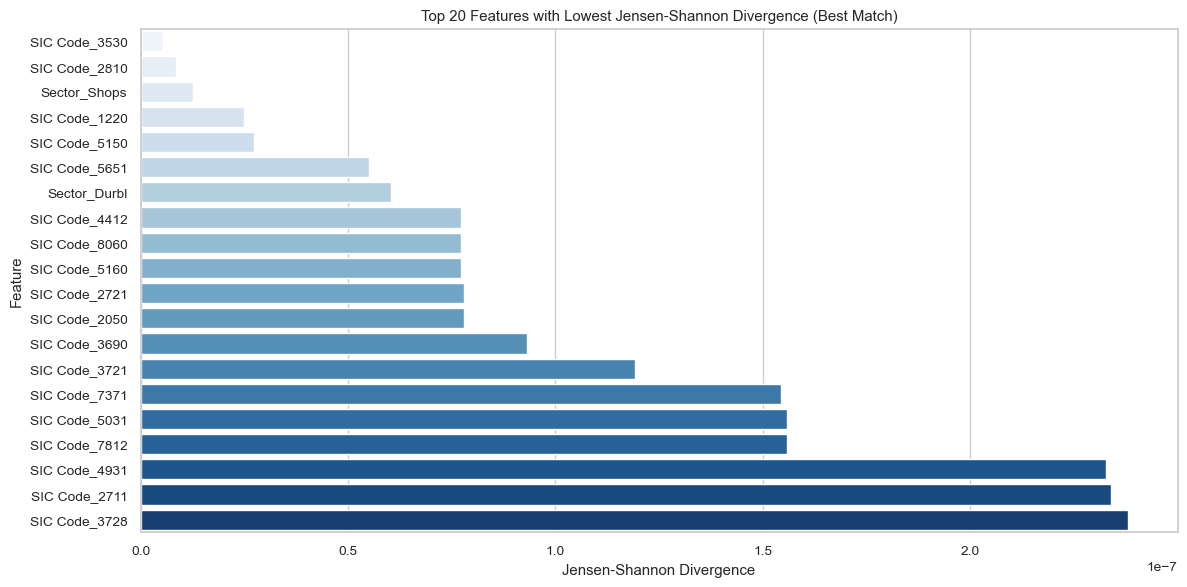

In [44]:
best20_jsd = metrics_df.sort_values(by='JSD', ascending=True).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=best20_jsd,
    y='Column',
    hue='Column',
    x='JSD',
    palette='Blues'
)
plt.title("Top 20 Features with Lowest Jensen-Shannon Divergence (Best Match)")
plt.xlabel("Jensen-Shannon Divergence")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [45]:
# metrics_df.sort_values(by='Information_Loss_%', ascending=False).head(5)

In [46]:
# # Set style
# sns.set(style="whitegrid", font_scale=0.9)

# # Select top 20 features with highest information loss
# top20_loss = metrics_df.sort_values(by='Information_Loss_%', ascending=False).head(20)

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(
#     data=top20_loss,
#     y='Column',
#     x='Information_Loss_%',
#     hue='Column',         # satisfy future seaborn hue requirement
#     palette='Reds_r',
#     dodge=False,
#     legend=False
# )

# # Add text labels after bars
# for p in ax.patches:
#     value = p.get_width()
#     y = p.get_y() + p.get_height() / 2
#     ax.text(
#         value,        # position text slightly after the bar
#         y,
#         f"{value:.2f}%",    # show with two decimal places and a percent sign
#         va='center',
#         fontsize=9,
#         color='black'
#     )

# # Titles and layout
# plt.title("Top 20 Features with Highest Information Loss (KL Divergence)", fontsize=12, weight='bold')
# plt.xlabel("Information Loss (%)")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

In [47]:
# refined_df.to_csv("SyntheticData.csv")

In [48]:
# import pandas as pd
# synthetic_data = r"SyntheticData.csv"
# df = pd.read_csv("SyntheticData.csv")
# df.shape

In [ ]:
import pandas as pd

synthetic_data_path = r"SyntheticData.csv"
original_data_path = r"PreparedData.csv"

# Load both datasets
df_synth = pd.read_csv(synthetic_data_path)
# df_synth = df_synth.head(3195)
df_orig = pd.read_csv(original_data_path)

# Merge (vertical stack → same columns)
df_merged = pd.concat([df_orig, df_synth], ignore_index=True)

# Save the merged file
df_merged.to_csv("MergedData.csv", index=False)

print("Merged dataset shape:", df_merged.shape)


Merged dataset shape: (11000, 285)
